In [8]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import py21cmfast as p21c
import h5py
import powerbox

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file(f"{WDIR}/matplotlibrc")

In [6]:
outputs_dir = "/n/holylabs/LABS/iaifi_lab/Users/yitians/dm21cm/outputs"

bkg_fn = f"{outputs_dir}/bkg/LightCones/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_fid_r54321.h5"
#inj_small_fn = f"{outputs_dir}/inhom-hom-cmp/inhom_phot_m5e3_lt1e26_stdastro/LightCones/Lightcone_I0_D0.h5"
inj_large_fn = f"{outputs_dir}/inhom-hom-cmp/inhom_phot_m5e3_lt1e26_stdastro/LightCones/Lightcone_I0_D0.h5"

In [21]:
lc_bkg = p21c.LightCone.read(bkg_fn)
#lc_small = p21c.LightCone.read(inj_small_fn)
lc_large = p21c.LightCone.read(inj_large_fn)

In [14]:
def compute_power(
   box,
   length,
   n_psbins,
   log_bins=True,
   ignore_kperp_zero=True,
   ignore_kpar_zero=False,
   ignore_k_zero=False,
):
    # Determine the weighting function required from ignoring k's.
    k_weights = np.ones(box.shape, int)
    n0 = k_weights.shape[0]
    n1 = k_weights.shape[-1]

    if ignore_kperp_zero:
        k_weights[n0 // 2, n0 // 2, :] = 0
    if ignore_kpar_zero:
        k_weights[:, :, n1 // 2] = 0
    if ignore_k_zero:
        k_weights[n0 // 2, n0 // 2, n1 // 2] = 0

    res = powerbox.tools.get_power(
        box,
        boxlength=length,
        bins=n_psbins,
        bin_ave=False,
        get_variance=False,
        log_bins=log_bins,
        k_weights=k_weights,
    )

    res = list(res)
    k = res[1]
    if log_bins:
        k = np.exp((np.log(k[1:]) + np.log(k[:-1])) / 2)
    else:
        k = (k[1:] + k[:-1]) / 2

    res[1] = k
    return res

BOX_LEN = 256
HII_DIM = 128

k_fundamental = 2*np.pi / BOX_LEN
k_max = k_fundamental * HII_DIM
Nk = np.floor(HII_DIM).astype(int)

def get_chunk_indices(brightness_temp, nchunks):
    return list(range(0,brightness_temp.n_slices,round(brightness_temp.n_slices / nchunks),))

def powerspectra(brightness_temp, n_psbins=50, nchunks=20, min_k=0.1, max_k=1.0, logk=True):
    data = []
    chunk_indices = get_chunk_indices(brightness_temp, nchunks)
    
    if len(chunk_indices) > nchunks:
        chunk_indices = chunk_indices[:-1]
    chunk_indices.append(brightness_temp.n_slices)

    for i in range(nchunks):
        start = chunk_indices[i]
        end = chunk_indices[i + 1]
        chunklen = (end - start) * brightness_temp.cell_size

        power, k = compute_power(
            brightness_temp.brightness_temp[:, :, start:end],
            (BOX_LEN, BOX_LEN, chunklen),
            n_psbins,
            log_bins=logk,
        )
        data.append({"k": k, "delta": power * k ** 3 / (2 * np.pi ** 2)})
    return data

In [23]:
ps_bkg = powerspectra(lc_bkg, min_k=k_fundamental, max_k=k_max)
ps_large = powerspectra(lc_large, min_k=k_fundamental, max_k=k_max)

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/powerbox/tools.py:325: UserWarning: One or more radial bins had no cells within it.
  return angular_average(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/powerbox/tools.py:180: RuntimeWarning: invalid value encountered in divide
  np.bincount(


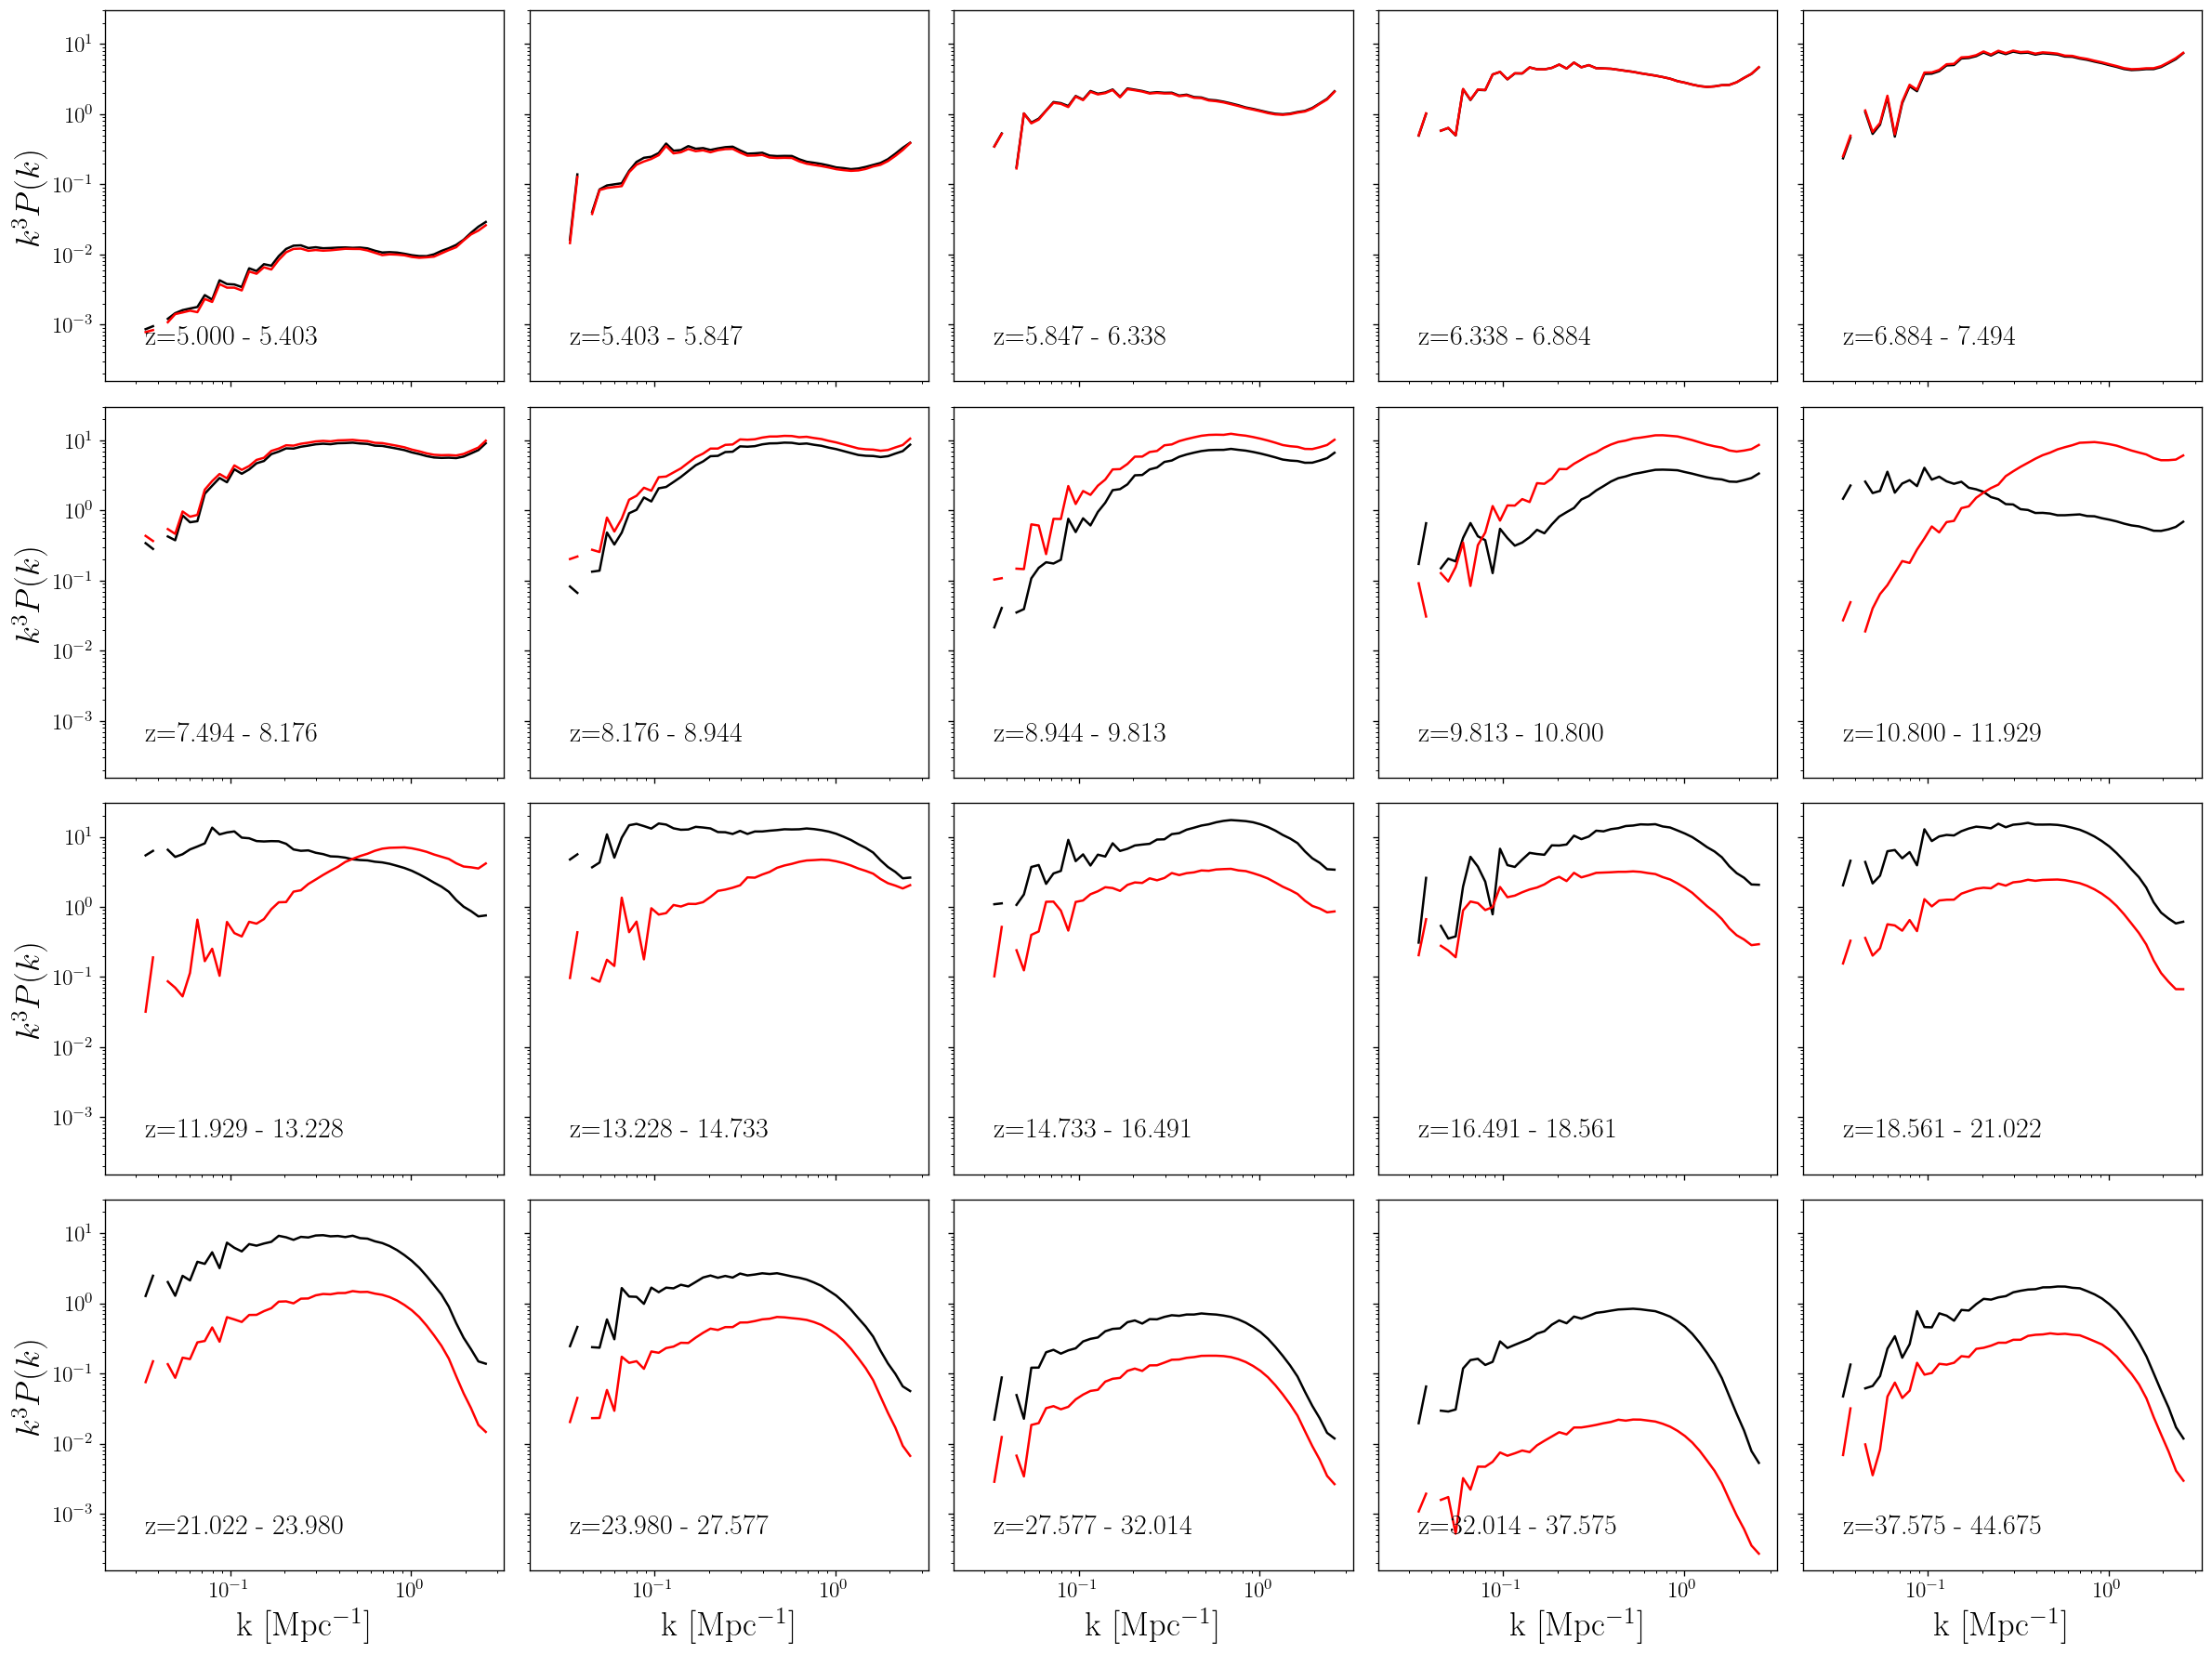

In [27]:
fig, axs = plt.subplots(4, 5, figsize = (20, 15), sharex = True, sharey = True)

chunk_inds = get_chunk_indices(lc_bkg, 20)
z_s = lc_bkg.lightcone_redshifts

for i, (ps, psl) in enumerate(zip(ps_bkg, ps_large)):
    ri, ci = np.unravel_index(i, axs.shape)
    ax = axs[ri, ci]

    ax.plot(ps['k'], ps['delta'], color='k')
    ax.plot(psl['k'], psl['delta'], color='r')
    ax.set(xscale='log', yscale='log')

    ax.text(.1, .1, f'z={z_s[chunk_inds[i]]:.3f} - {z_s[chunk_inds[i+1]]:.3f}', transform=ax.transAxes, fontsize=18)

for j in range(axs.shape[1]):
    axs[-1, j].set_xlabel('k [Mpc$^{-1}$]', fontsize = 22)
for i in range(axs.shape[0]):
    axs[i, 0].set_ylabel('$k^3 P(k)$', fontsize = 22)
    
plt.tight_layout()
plt.show()

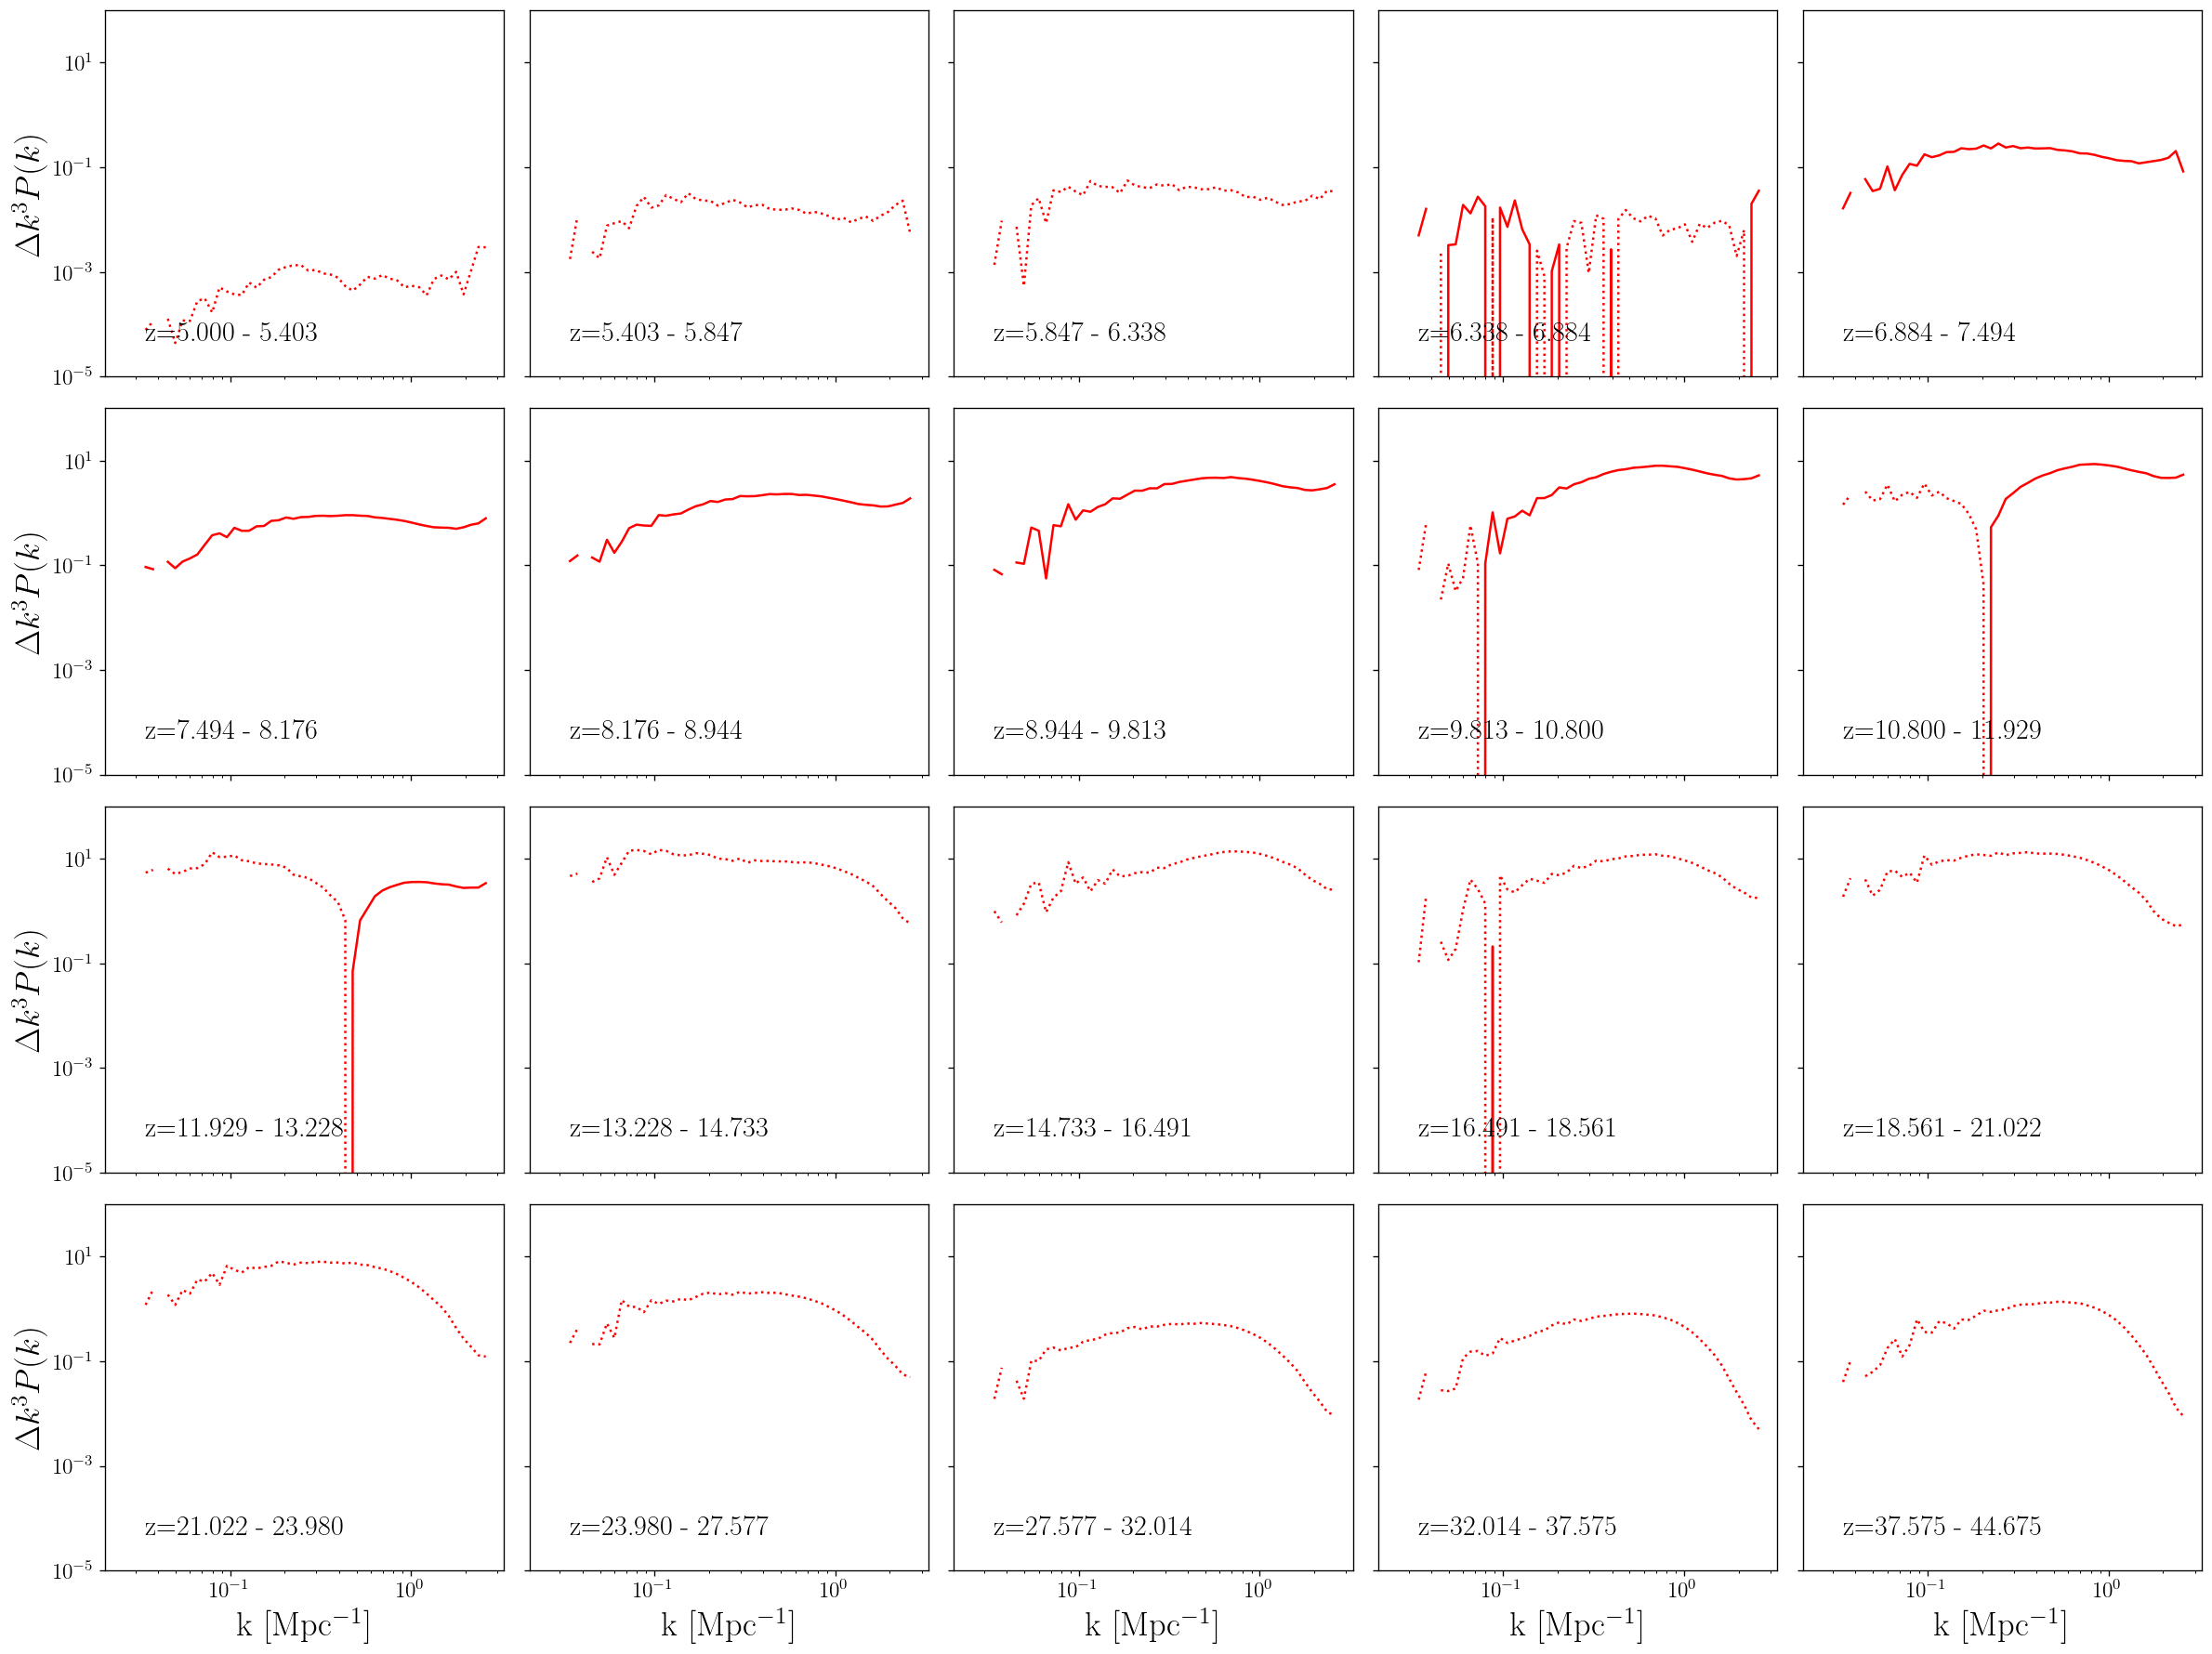

In [32]:
fig, axs = plt.subplots(4, 5, figsize = (20, 15), sharex = True, sharey = True)

chunk_inds = get_chunk_indices(lc_bkg, 20)
z_s = lc_bkg.lightcone_redshifts

for i, (ps, psl) in enumerate(zip(ps_bkg, ps_large)):
    ri, ci = np.unravel_index(i, axs.shape)
    ax = axs[ri, ci]
    ax.plot(psl['k'], psl['delta']-ps['delta'], color='r')
    ax.plot(psl['k'], -(psl['delta']-ps['delta']), color='r', ls=':')
    ax.text(.1, .1, f'z={z_s[chunk_inds[i]]:.3f} - {z_s[chunk_inds[i+1]]:.3f}', transform=ax.transAxes, fontsize=18)

axs[0, 0].set(xscale='log', yscale='log', ylim=(1e-5, 1e2))

for j in range(axs.shape[1]):
    axs[-1, j].set_xlabel(r'k [Mpc$^{-1}$]', fontsize = 22)
for i in range(axs.shape[0]):
    axs[i, 0].set_ylabel(r'$\Delta k^3 P(k)$', fontsize = 22)
    
plt.tight_layout()
plt.show()